<a href="https://colab.research.google.com/github/guard1000/NLP_MCC/blob/master/5_2_keras_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

keras-bert를 활용하여 3_just_tfidf.ipynb, 4_LSTM_MLP_CNN_RCNN_Draft_Preprocess.ipynb 에서 수행했던 뉴스 주제 분류를 동일 데이터로 수행

기존의 LSTM, MLP, CNN, RCNN에 비해 확실히 우수한 성능을 보여줌. 버트 갓갓



[결론]

메모리 용량 문제로

최대 길이 : 16334 word, 평균 길이 : 930.4483 word

데이터를 별도 전처리 없이 입력으로 주고, 모델 내에서 형태소 분석 이후 앞 128개 토큰만 가지고 돌린것을 감안하면 f1 - 0.8은 상당히 괜찮아 보임

VoC분류 데이터가 평균 126 word, 최대 1172 word 이므로, BERT 적용으로 성능이 제법 높게 나올 것으로 예상


주요 참고자료: kimwoonggon님 keras-bert

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [2]:
#오늘의 핵심
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=6c9523c3f88d95e193e0a61589a1f410c1c54d3e990bdf9bf3d3e131b32c4895
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=16a906250f650dce29d660203de7cdcf98c3e5706277483a18b4705c1e1db508
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=6e6619493c2e46eae736ac922d202745299148393013a939649d81d371c5cb58
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=e6a8b049ce2af7002b776fbd517d966ab4ed2417a6a4df8d4242b7194c6aca00
  Stor

In [0]:
# keras_bert의 모듈들 import
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
dummy = pd.read_csv("/content/drive/My Drive/data/Article_shuffled.csv")
dummy.rename(columns={'이해찬 민주당 단배식서 내년 총선 압승해 민주주의 정착 새해 첫날인 1일 여권은 집권 3년 차를 맞은 문재인 정부의 성공을 기원하며 내부 결속 의지를 다졌다. 특히 여당인 더불어민주당은 2020년 총선 압승 을 발판으로 2022년 정권 재창출 을 이뤄내겠다고 다짐했다. 문희상 국회의장은 이날 서울 한남동 의장 공관에서 신년 기자간담회를 열고 집권 3년 차는 아주 중요한 전기 라고 했다. 그러면서 올해를 황금돼지해라고 부르는데 저는 검은 돼지든 흰 돼지든 무게만 나가면 된다고 생각한다 며 흑돈백돈 黑豚白豚 론 을 펼쳤다. 중국 덩샤오핑의 흑묘백묘론 검은 고양이든 흰 고양이든 쥐만 잘 잡으면 된다 을 차용해 올해 경제 발전이 가장 중요한 과제라는 점을 강조한 것으로 해석됐다. 문 의장은 황금으로 누런 돼지라고 하면 이건 정말 대박 이라며 번영의 돼지해에 문재인 정부도 성공하고 우리도 성공하는 한 해가 되길 바란다 고 했다. 민주당은 이날 여의도 당사에서 신년인사회를 겸한 단배식을 열었다. 이해찬 대표는 재작년에는 정권 교체를 이뤘고 작년에는 지방선거에서 민주당이 압도적 승리를 거뒀다 며 이것을 기반으로 내년 총선에서 아주 크게 압승하는 정치적 성과를 올려야 한다 고 했다. 이 대표는 총선에서 크게 이기는 게 이 나라 민주주의를 정착시키는 데 아주 중요한 과업 이라며 그래야 2022년 대선에서 정권을 재창출해 민주당이 평화와 민주주의를 지키는 마지막 보루가 될 수 있다 고 했다. 이 대표는 남북 관계와 관련해 지난해 70년 분단 체제에서 평화 체제로 전환되는 역사적 한 획을 그었다 며 아마 남북 정상회담이 올해 일찍 열릴 가능성이 크다 고 했다. 경제 문제에 대해선 어렵다곤 하지만 조금씩은 나아지고 있다 고 했다. 그러자 홍영표 원내대표는 맞바람을 향해 돛을 펼친다 는 역풍장범 逆風張帆 이라는 말이 있다 며 앞으로도 많은 시련과 도전이 기다리고 있다. 이 대표를 중심으로 더욱 단결하는 한 해가 되도록 하자 고 했다. 민주당 지도부는 이날 오전 서울 국립현충원에서 김영삼·김대중 전 대통령 묘역을 참배했다. 이어 이승만·박정희 전 대통령 묘역도 찾았으나 일부 시민이 어떻게 박 전 대통령 묘역에 인사할 수 있나. 부끄럽지도 않으냐 고 항의해 분위기가 일순간 얼어붙기도 했다. 오후에는 경남 김해 봉하마을을 방문해 노무현 전 대통령 묘역을 참배했다.' : 'document', '정치': 'label'}, inplace=True)

dic_category = {'경제': 0, '생활문화': 1, 'IT과학': 2, '정치': 3, '사회': 4, '오피니언': 5, '세계':6}
for i in range(11000):
  dummy.iloc[i].label = dic_category[dummy.iloc[i].label]

train = dummy[:10000]
test = dummy[10000:11000]

In [5]:
train[:20]
test[-20:]

,document,label
10980,JW그룹은 업무 효율화 차원에서 공식적인 행사 없이 각 업무 현장에서 새해를 시작했...,1
10981,2019년 주목할 웨어러블 제품 7選 올해 주목받을 새로운 기술의 트렌드 중 하나는...,2
10982,태어나자마자 한 살이 되고 설날마다 나이를 먹는 이른바 ‘한국식 나이’를 만나이로 ...,5
10983,지난해 우리나라 수출이 사상 최대인 6천55억 달러로 집계됐습니다. 이는 2017년...,0
10984,머니투데이 마아라 기자 tvN 인기 드라마 남자친구 연일 화제…극중 박보검 사로 잡...,1
10985,서울경제 새해 적용되는 건설공사 표준시장단가가 지난해 하반기 대비 3.39% 상승했...,0
10986,한정우 경남 창녕군수 연합뉴스 자료사진 창녕 연합뉴스 이정훈 기자 한정우 경남 창녕...,4
10987,9·13대책 발표전 거래효과 끝나 거래절벽에 관련 산업 직격탄 서울 아파트값 15개...,0
10988,머니투데이 박계현 기자 베스트리포트 윤재성·김정현 하나금융투자 연구원 3일 머니투데...,0
10989,서울 뉴시스 박미소 수습기자 지난 4일 서울시 금천구청장실에서 유성훈 왼쪽 세번째부...,3


뉴스 기사 최대 길이 : 16334
뉴스 기사 평균 길이 : 930.4483


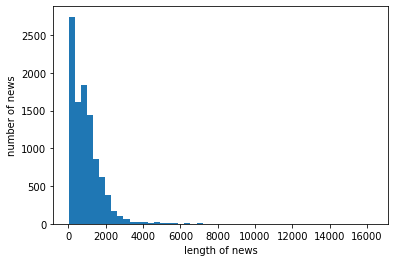

In [6]:
# 전체 데이터 중 가장 긴 뉴스, 뉴스들 평균  길이로 어느정도 길이로 잘라낼지 확인
import matplotlib.pyplot as plt

print('뉴스 기사 최대 길이 :',max(len(l) for l in train.document))
print('뉴스 기사 평균 길이 :',sum(map(len, train.document))/len(train.document))
plt.hist([len(s) for s in train.document], bins=50)
plt.xlabel('length of news')
plt.ylabel('number of news')
plt.show()

In [7]:
#전체 데이터 중 특정 length 이하인 비율을 알려주는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 데이터 중 길이가 %s 이하인 데이터의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 128  # 위 그래프 보면서 임의로 값 넣어보면서 비율 확인 - 성능 별로면 이거 올려
below_threshold_len(max_len, train.document)

전체 데이터 중 길이가 128 이하인 데이터의 비율: 17.169999999999998


In [0]:
SEQ_LEN = max_len      # 문장의 최대 길이. 더 짧으면 0 패딩, 길면 뒤는 잘라냄
BATCH_SIZE = 32    # 메모리 초과할까봐 일단 16으로 작게 함. 돌려보고 더 크게 키워도 됨
EPOCHS=4           # 에퐄도 학습 더 시켜도 됨
LR=1e-5            # Learning Rate 일단 작게 줘봄. 키워도 됨

pretrained_path ='/content/drive/My Drive/data/bert2'
config_path = '/content/drive/My Drive/data/bert2/bert_config.json'
checkpoint_path = '/content/drive/My Drive/data/bert2/bert_model.ckpt'
vocab_path = '/content/drive/My Drive/data/bert2/vocab.txt'

DATA_COLUMN = 'document' # 쿼리
LABEL_COLUMN = 'label'   # GT

In [0]:
# token_dict - voacab.txt 단어에 index 추가하는 딕셔너리
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
# inherit_Tokenizer 클래스 - Tokenizer 클래스를 상속 받아옴
# _tokenize() 함수 재정의
# --원래 클래스를 그대로 사용하면 입력한 문장이 완전 자모분리 되어버림
# --완전자모분리 : 인공지능 -> ㅇ ㅣ ㄴ ㄱ ㅗ ㅇ ㅈ ㄴ ㅡ ㅇ

class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

In [12]:
# tokenizer 확인
# 버트에선 문장 시작에 [CLS],  문장 끝에 [SEP]이 추가됨
tokenizer.tokenize("SKT Infra AI/DT 추진Cell 최고야")

['[CLS]',
 'sk',
 '##t',
 'in',
 '##fra',
 'ai',
 '/',
 'dt',
 '추',
 '##진',
 '##cell',
 '최고',
 '##야',
 '[SEP]']

In [0]:
# 버트 모형의 입력에 맞게 변형해주는 함수 정의
# --tokenizer.encode()로 버트 모형 토큰화 한 후 단어-인덱스에 맞춰 숫자로 바꿔줌
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

In [14]:
# 데이터 셋 분할 - 10000개
train_x, train_y = load_data(train)
#test_x, test_y = load_data(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
100%|██████████| 10000/10000 [00:23<00:00, 427.69it/s]


In [15]:
test.index = np.arange(0, len(test))
test_x, test_y = load_data(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
100%|██████████| 1000/1000 [00:02<00:00, 408.80it/s]


In [16]:
# pre-trained 버트 모델의 인풋:
# -- 1) 숫자로 표현된 문장토큰
# -- 2) 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터
print(len(train_x))
print(len(train_x[0]), len(train_x[1])) # 10000개
print(len(train_x[0][0]),len(train_x[1][0]))     # SEQ_LEN
train_x

2
10000 10000
128 128


[array([[   101,   9706,  33305, ...,    119,   9706,    102],
        [   101,   9637,  40991, ...,   9637,  40991,    102],
        [   101,   9954,  36553, ...,  39420,  71439,    102],
        ...,
        [   101,   9612,  16323, ...,      0,      0,      0],
        [   101,   9665,  30858, ..., 119253,  11287,    102],
        [   101,   8935,  16605, ...,   9365,  55635,    102]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [0]:
# 버트 모형에 들어갈 인풋은 1)토큰, 2)세그먼트, 3)포지션
# 1) 토큰 - 토큰화 된 것이 인덱싱되어 숫자로 변환된 것
# 2) 세그먼트 - 앞문장인지 뒷문장인지 알려주는 숫자들
#     -- 지금은 그냥 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 패딩
# 3) 포지션 - 단어 순서에 따라서 자동으로 부여

def sentence_convert_data(data):
    global tokenizer #아까 만들어둔 inherit tokenizer 불러옴
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
    data_x = sentence_convert_data(sentences)
    return data_x

In [18]:
sentence_load_data(["SKT Infra AI/DT 추진Cell 최고야", "케라스 버트 사랑해요"])

100%|██████████| 2/2 [00:00<00:00, 645.43it/s]

['[CLS]', 'sk', '##t', 'in', '##fra', 'ai', '/', 'dt', '추', '##진', '##cell', '최고', '##야', '[SEP]']
['[CLS]', '케', '##라', '##스', '버', '##트', '사', '##랑', '##해', '##요', '[SEP]']


[array([[   101,  66998,  10123,  10106,  31162,  11346,    120,  29169,
           9765,  18623, 110300,  83491,  21711,    102,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,   

In [19]:
# Pretrained Model을 로드
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









In [20]:
#모델 어캐 생겼냐 - 12 layer
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
# 사전학습 모델을 변형해보자
# input으로 토큰벡터, 세그먼트만 넣을꺼라서 inputs = model.inputs[:3]
# output은 사전학습 모델을 잘라주자. 
# --(outputs=Dense(7)) 맨 위 3층을 잘라내고 True/False를 알려주는 Dense(7)을 추가해보자
# --Dense(1) 로 하면 아웃풋이 하나! 긍정일수록 0, 부정일수록 1
# Radam으로 Gradient Descent 해준 후 모델을 return
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output

  outputs = keras.layers.Dense(7, activation='softmax',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)

  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

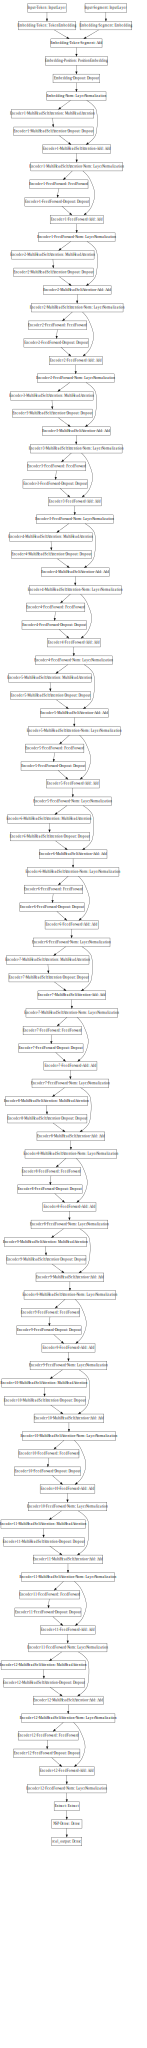

In [22]:
# 모델의 Flow 확인
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [23]:
# bert_model을 get_bert_finetuning_model함수로 불러오고
# bert_model.fit으로 파인튜닝
# 실시간 정확도 체크- validation_data = (test_x, test_y)
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=10, batch_size=32, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

bert_model.save_weights("/content/drive/My Drive/data/bert2/bert.h5")


Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 195s 19ms/step - loss: 1.2041 - acc: 0.7288 - val_loss: 0.7623 - val_acc: 0.7860
Epoch 2/10
10000/10000 [==============================] - 174s 17ms/step - loss: 0.5305 - acc: 0.8614 - val_loss: 0.6538 - val_acc: 0.7910
Epoch 3/10
10000/10000 [==============================] - 174s 17ms/step - loss: 0.4017 - acc: 0.8833 - val_loss: 0.6936 - val_acc: 0.7790
Epoch 4/10
10000/10000 [==============================] - 174s 17ms/step - loss: 0.3332 - acc: 0.9031 - val_loss: 0.7331 - val_acc: 0.7800
Epoch 5/10
10000/10000 [==============================] - 174s 17ms/step - loss: 0.2944 - acc: 0.9099 - val_loss: 0.6799 - val_acc: 0.7950
Epoch 6/10
10000/10000 [==============================] - 174s 17ms/step - loss: 0.2502 - acc: 0.9266 - val_loss: 0.7990 - val_acc: 0.7770
Epoch 7/10
10000/10000 [==============================] - 174s 17ms/step - loss: 0.2198 - acc: 0.9349 - val_loss: 0.7

In [0]:
# 모델 로드
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights("/content/drive/My Drive/data/bert2/bert.h5")


In [0]:
# 테스트 데이터를 버트 모형에 넣을 수 있게 해주는 predict_convert_data 함수
# convert_data 함수와 다른 점 : test 데이터이므로 label은 고려하지 않음
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [25]:
test_set = predict_load_data(test)
test_set

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 1000/1000 [00:02<00:00, 408.21it/s]


[array([[   101,   8996,  89851, ...,   8908,  14843,    102],
        [   101,  48253,   9039, ...,      0,      0,      0],
        [   101,   9678,  16758, ...,  71771,   8987,    102],
        ...,
        [   101,    123,  23466, ...,  96618,  67313,    102],
        [   101,  23545,   8896, ..., 109265,  20479,    102],
        [   101,  48253,   9039, ...,   9429,  29455,    102]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [44]:
# 테스트 셋으로 예측
preds = bert_model.predict(test_set)
preds


array([[2.4146952e-03, 2.2869334e-03, 8.3967578e-04, ..., 9.9153215e-01,
        6.2151923e-04, 1.2050447e-03],
       [5.3391978e-03, 1.2908488e-03, 5.3545414e-04, ..., 9.8489517e-01,
        5.4246280e-04, 1.0054876e-03],
       [1.0125092e-03, 7.5526553e-04, 3.8176024e-04, ..., 2.4084537e-03,
        4.1519248e-04, 2.3814694e-03],
       ...,
       [5.4916280e-04, 7.2895660e-04, 8.3165901e-04, ..., 9.6800615e-04,
        9.9419254e-01, 1.7801088e-03],
       [1.7312996e-03, 1.3392443e-03, 2.6413344e-03, ..., 1.6866939e-03,
        2.4375906e-03, 9.8029035e-01],
       [4.1024578e-01, 2.6464632e-01, 7.8294620e-02, ..., 3.2043315e-03,
        6.8191732e-03, 8.2481531e-03]], dtype=float32)

In [45]:
from sklearn import metrics

answer = [np.argmax(i) for i in preds]
y_true = [i for i in test['label']]

ac_score = metrics.accuracy_score(y_true, answer)
cl_report = metrics.classification_report(y_true, answer)
print("정답률 =", ac_score)
print("리포트 =\n", cl_report)

정답률 = 0.796
리포트 =
               precision    recall  f1-score   support

           0       0.69      0.75      0.72       148
           1       0.79      0.74      0.76       139
           2       0.88      0.88      0.88       168
           3       0.81      0.77      0.79       167
           4       0.74      0.83      0.78       161
           5       0.86      0.84      0.85       160
           6       0.83      0.68      0.75        57

    accuracy                           0.80      1000
   macro avg       0.80      0.78      0.79      1000
weighted avg       0.80      0.80      0.80      1000

